# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import FileLink
import seaborn as sns
import re

from pymatgen.core import Composition
from pymatgen.core.periodic_table import Element
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

# Functions

In [19]:
def parse_formula(formula):
    """
    Parse a chemical formula into a Composition object.

    Parameters:
    formula (str): The chemical formula to parse.

    Returns:
    Composition: The parsed composition object or None if parsing fails.
    """
    try:
        comp = Composition(formula)
        return comp
    except ValueError:
        return None  

def add_element_properties(element_symbol):
    """
    Add properties for a given element.

    Parameters:
    element_symbol (str): The symbol of the element to add properties for.

    Returns:
    dict: A dictionary of the element's properties.
    """
    element = Element(element_symbol)
    new_properties = {}
    for prop in element_properties:
        new_properties[prop] = getattr(element, prop, None)

    return new_properties

def composition_to_dict(c):
    """
    Convert a Composition object to a dictionary.

    Parameters:
    c (Composition or dict or str): The composition to convert.

    Returns:
    dict: The unit cell composition as a dictionary.
    """
    if isinstance(c, dict):
        unit_cell_composition = c
    else:
        if isinstance(c, str):
            c = Composition(c)
        unit_cell_composition = c.to_data_dict["unit_cell_composition"]
        
    return unit_cell_composition

def compute_average_from_composition(c, prop):
    """
    Compute the average property value from a composition.

    Parameters:
    c (dict): The composition dictionary.
    prop (str): The property to compute the average for.

    Returns:
    float: The average property value or NaN if no valid elements are found.
    """
    res = 0
    total = 0
    for i, j in c.items():
        if i in element_df.index:
            res += element_df.loc[i, prop] * j
            total += j
        else:
            print(f"Warning: Element {i} not found in element DataFrame.")
    return res / total if total > 0 else np.nan

def get_maxmin_properties(c, prop, mode):
    """
    Get the maximum or minimum property value from a composition.

    Parameters:
    c (dict): The composition dictionary.
    prop (str): The property to get the max/min for.
    mode (str): 'max' for maximum, 'min' for minimum.

    Returns:
    float: The max or min property value or NaN if no valid elements are found.
    """
    values = []
    for element, amount in c.items():
        if element in element_df.index:
            values.append(element_df.loc[element, prop])
        else:
            print(f"Warning: Element {element} not found in element DataFrame.")

    if not values:  # Check if the values list is empty
        return np.nan
    return max(values) if mode == "max" else min(values)

def get_stdvar_properties(c, prop, mode):
    """
    Get the standard deviation or variance of a property from a composition.

    Parameters:
    c (dict): The composition dictionary.
    prop (str): The property to get the std/var for.
    mode (str): 'std' for standard deviation, 'var' for variance.

    Returns:
    float: The std or var property value or NaN if no valid elements are found.
    """
    values = []
    for element, amount in c.items():
        if element in element_df.index:
            values.append(element_df.loc[element, prop])
        else:
            print(f"Warning: Element {element} not found in element DataFrame.")

    if not values:  # Check if the values list is empty
        return np.nan
    return np.std(values, ddof=1) if mode == "std" else np.var(values, ddof=1)

def remove_duplicates(df, subset_column):
    """
    Function to remove duplicates and NaN values from a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to clean.
    subset_column (str): The column to check for duplicates.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    print("Number of compounds before removing Duplicates:", df.shape[0])
    # Remove Duplicates
    df = df.drop_duplicates(subset=subset_column, keep='first')
    print("Number of compounds after removing Duplicates:", df.shape[0])
    
    return df

def remove_missing(df, subset_column):
    """
    Function to remove duplicates and NaN values from a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to clean.
    subset_column (str): The column to check for missing data.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    
    print("Number of compounds before removing NaN values:", df.shape[0])
    # Remove NaN
    df = df.dropna()
    print("Number of compounds after removing NaN values:", df.shape[0])
    
    return df

def classify_compound(elements):
    """
    Function to classify types of superconductor
    """
    if 'Cu' in elements and 'O' in elements:
        return 'Cuprates'
    elif 'Fe' in elements:
        return 'Fe-based'
    elif 'H' in elements:
        return 'Hydrides'
    else:
        return 'Other'

def clean_problematic(df):
    """
    Clean the superconductors DataFrame based on specified criteria.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing superconductors data.
    
    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    print("Number of compounds before removal of problematic data:", df.shape[0])
    
    # 1) Eliminate compounds with element subscripts X, Y, Z, D, x, y, z, and d
    problematic_subscripts = ['X', 'Y', 'Z', 'D', 'x', 'y', 'z', 'd']
    df = df[~df['chemical_formula'].str.contains('|'.join(problematic_subscripts))]
    
    # 2) Remove problematic compounds with specified names
    problematic_compounds = [
        'HgSr2Ho0.333Ce0.667Cu2O6=z', 'Ba2Cu1.2Co2.4O2,4', 'Ag7Bf4O8',
        'Hg0.3Pb0.7Sr1.75La0.25CuO4+2', 'Ho0.8Ca0.2Sr2Cu2.8P0.2Oz+0.8',
        'Bi1.6Pb0.4Sr2Ca2Cu3F0.8Oz-0.8'
    ]
    df = df[~df['chemical_formula'].isin(problematic_compounds)]
    
    # 3) Remove compounds created under non-ambient pressures
    non_ambient_pressure_compounds = ['La1H10', 'H2S1', 'H3S1', 'D3S1']
    df = df[~df['chemical_formula'].str.contains('|'.join(non_ambient_pressure_compounds))]
    
    # 4) Eliminate the specific compound with an incorrect oxygen subscript
    df = df[~df['chemical_formula'].str.contains('YBa2CuO6050')]
    
    # 5) Dismiss compounds whose transition temperatures are reported to be zero
    df = df[df['Tc'] != 0]
    
    # 6) Discard the specific compound due to the unreasonable transition temperature
    df = df[~df['chemical_formula'].str.contains('Pb2CAg2O6')]

    # 7) Removing compounds that are not in the periodic table
    elements_to_remove = {'D', 'Cm', 'T','M', 'Rr', 'Jr'}
    filter_mask = df['stoichiometry'].apply(lambda d: not any(elem in elements_to_remove for elem in d))
    df = df[filter_mask]

    print("Number of compounds after removal of problematic data:", df.shape[0])
    
    return df

def clean_outliers(df):
    """
    Clean the superconductors DataFrame by removing outliers based on specified criteria.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing superconductors data.
    
    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    print("Number of compounds before outlier removal:", df.shape[0])
    
    # 1) Remove transition temperature outliers
    df = df[(df['Tc'] >= 0.01) & (df['Tc'] <= 136)].copy()
    
    # 2) Remove rows with problematic number of elements
    def count_elements(chemical_formula):
        # Extract elements using regex
        elements = re.findall(r'([A-Z][a-z]*)', chemical_formula)
        return len(elements)
    
    df.loc[:, 'num_elements'] = df['chemical_formula'].apply(count_elements)
    df = df[~df['num_elements'].isin([1, 8, 10])].copy()
    
    # 3) Remove rows where summation of subscripts exceeds 100 using the stoichiometry column
    def sum_subscripts(stoichiometry):
        # Sum the subscripts in the stoichiometry dictionary
        return sum(stoichiometry.values())
    
    df.loc[:, 'subscripts_sum'] = df['stoichiometry'].apply(sum_subscripts)
    df = df[df['subscripts_sum'] <= 100].copy()
    
    # Drop the temporary columns used for calculations
    df = df.drop(columns=['num_elements', 'subscripts_sum'])

    print("Number of compounds after outlier removal:", df.shape[0])
    
    return df

# Import Data

In [20]:
# We are going to try create our own Dataset by cleaning Supercon_data.csv
# Let's call our data set "Data139"

supercond_df = pd.read_csv('/Users/chalachkasemtantikul/Downloads/primary.tsv', sep='\t')

supercond_df = supercond_df[['6', '92']]
supercond_df.columns = ['chemical_formula', 'Tc']
supercond_df = supercond_df.iloc[2:]
supercond_df['Tc'] = pd.to_numeric(supercond_df['Tc'], errors='coerce')

# Create Composition, Elements, and Stoichometry

supercond_df['composition'] = supercond_df['chemical_formula'].apply(parse_formula)
supercond_df = supercond_df[supercond_df['composition'].notnull()]
supercond_df['elements'] = supercond_df['composition'].apply(lambda comp: list(comp.elements))
supercond_df['stoichiometry'] = supercond_df['composition'].apply(lambda comp: {str(elem): amt for elem, amt in comp.get_el_amt_dict().items()})

# Keep old supercond_df for comparison later

old_supercond_df = supercond_df

display(supercond_df)

,chemical_formula,Tc,composition,elements,stoichiometry
20,La1.85Ba0.15Cu1O4,30.00,"(La, Ba, Cu, O)","[La, Ba, Cu, O]","{'La': 1.85, 'Ba': 0.15, 'Cu': 1.0, 'O': 4.0}"
21,La1.85Sr0.15Cu1O4,39.00,"(La, Sr, Cu, O)","[La, Sr, Cu, O]","{'La': 1.85, 'Sr': 0.15, 'Cu': 1.0, 'O': 4.0}"
35,Y0.4Ba0.6Cu1OX,90.00,"(Y, Ba, Cu, O, X0+)","[Y, Ba, Cu, O, X0+]","{'Y': 0.4, 'Ba': 0.6, 'Cu': 1.0, 'O': 1.0, 'X'..."
36,Y0.4Ba0.6Cu1OX,90.50,"(Y, Ba, Cu, O, X0+)","[Y, Ba, Cu, O, X0+]","{'Y': 0.4, 'Ba': 0.6, 'Cu': 1.0, 'O': 1.0, 'X'..."
37,Er0.5Ba0.5Cu1OX,92.00,"(Er, Ba, Cu, O, X0+)","[Er, Ba, Cu, O, X0+]","{'Er': 0.5, 'Ba': 0.5, 'Cu': 1.0, 'O': 1.0, 'X..."
...,...,...,...,...,...
26318,Hf0.5Lu0.5P1.45S0.55,5.87,"(Hf, Lu, P, S)","[Hf, Lu, P, S]","{'Hf': 0.5, 'Lu': 0.5, 'P': 1.45, 'S': 0.55}"
26319,Hf0.4Lu0.6P1.45S0.55,5.00,"(Hf, Lu, P, S)","[Hf, Lu, P, S]","{'Hf': 0.4, 'Lu': 0.6, 'P': 1.45, 'S': 0.55}"
26320,Hf0.7Y0.3P1.45S0.55,4.53,"(Hf, Y, P, S)","[Hf, Y, P, S]","{'Hf': 0.7, 'Y': 0.3, 'P': 1.45, 'S': 0.55}"
26321,Hf0.6Y0.4P1.45S0.55,4.74,"(Hf, Y, P, S)","[Hf, Y, P, S]","{'Hf': 0.6, 'Y': 0.4, 'P': 1.45, 'S': 0.55}"


# EDA

In [21]:
all_elements = [elem for sublist in supercond_df['elements'] for elem in sublist]
unique_elements_count = len(set(all_elements))
print(f"Number of unique elements supercond_df: {unique_elements_count}")

num_unique_formulae_distinct = len(pd.unique(supercond_df['chemical_formula']))
print("Number of Unique formulaes in the supercond_df dataset:", num_unique_formulae_distinct)

Number of unique elements supercond_df: 93
Number of Unique formulaes in the supercond_df dataset: 14636


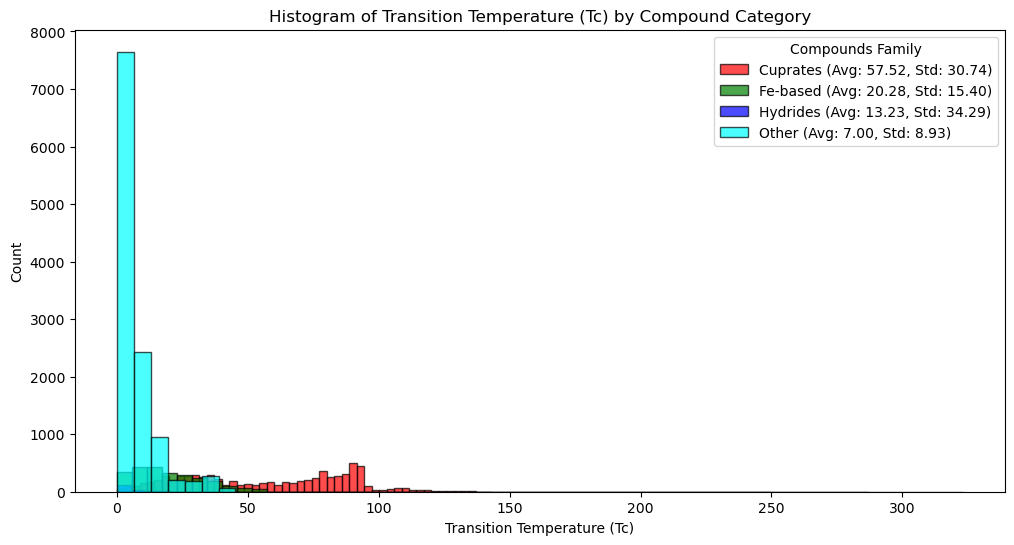

In [22]:
# Classify compounds for supercond_df
supercond_df['Category'] = supercond_df['composition'].apply(classify_compound)

# Define categories and colors
categories = ['Cuprates', 'Fe-based', 'Hydrides', 'Other']
colors = ['red', 'green', 'blue', 'cyan']

# Plotting the histogram
plt.figure(figsize=(12, 6))

for category, color in zip(categories, colors):
    subset = supercond_df[supercond_df['Category'] == category]
    avg_Tc = subset['Tc'].mean()
    std_Tc = subset['Tc'].std()
    plt.hist(subset['Tc'], bins=50, alpha=0.7, label=f'{category} (Avg: {avg_Tc:.2f}, Std: {std_Tc:.2f})', color=color, edgecolor='black')

plt.xlabel('Transition Temperature (Tc)')
plt.ylabel('Count')
plt.title('Histogram of Transition Temperature (Tc) by Compound Category')
plt.legend(title='Compounds Family')
plt.show()

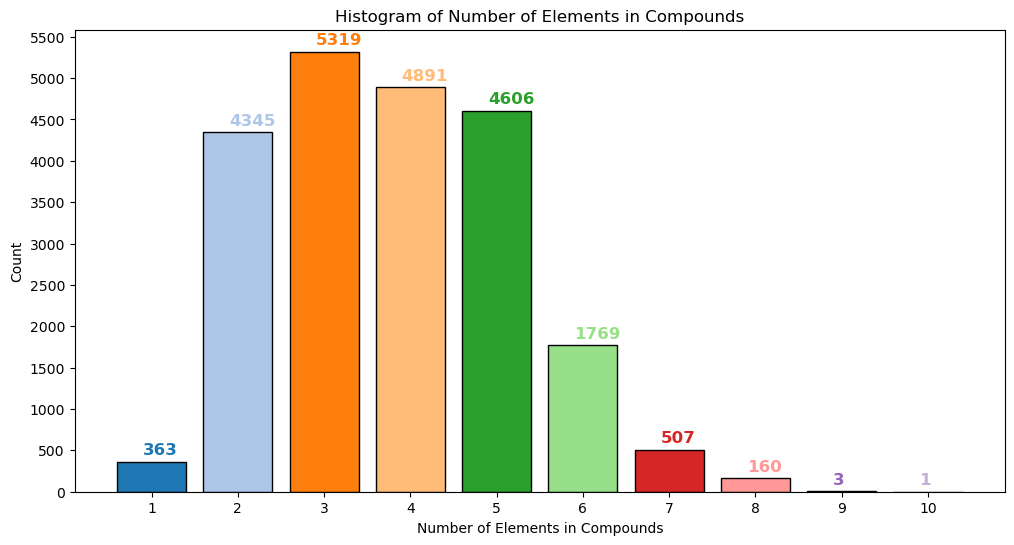

In [23]:
# Count the number of elements in each compound
supercond_df['num_elements'] = supercond_df['elements'].apply(len)

# Plot the histogram
element_counts = supercond_df['num_elements'].value_counts().sort_index()
colors = plt.cm.tab20.colors 

plt.figure(figsize=(12, 6))
bars = plt.bar(element_counts.index, element_counts.values, color=colors[:len(element_counts)], edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 50, int(yval), va='bottom', color=bar.get_facecolor(), fontsize=12, fontweight='bold')

plt.xlabel('Number of Elements in Compounds')
plt.ylabel('Count')
plt.title('Histogram of Number of Elements in Compounds')
plt.xticks(np.arange(1, supercond_df['num_elements'].max() + 1, step=1))
plt.yticks(np.arange(0, max(element_counts.values) + 500, step=500))

plt.show()

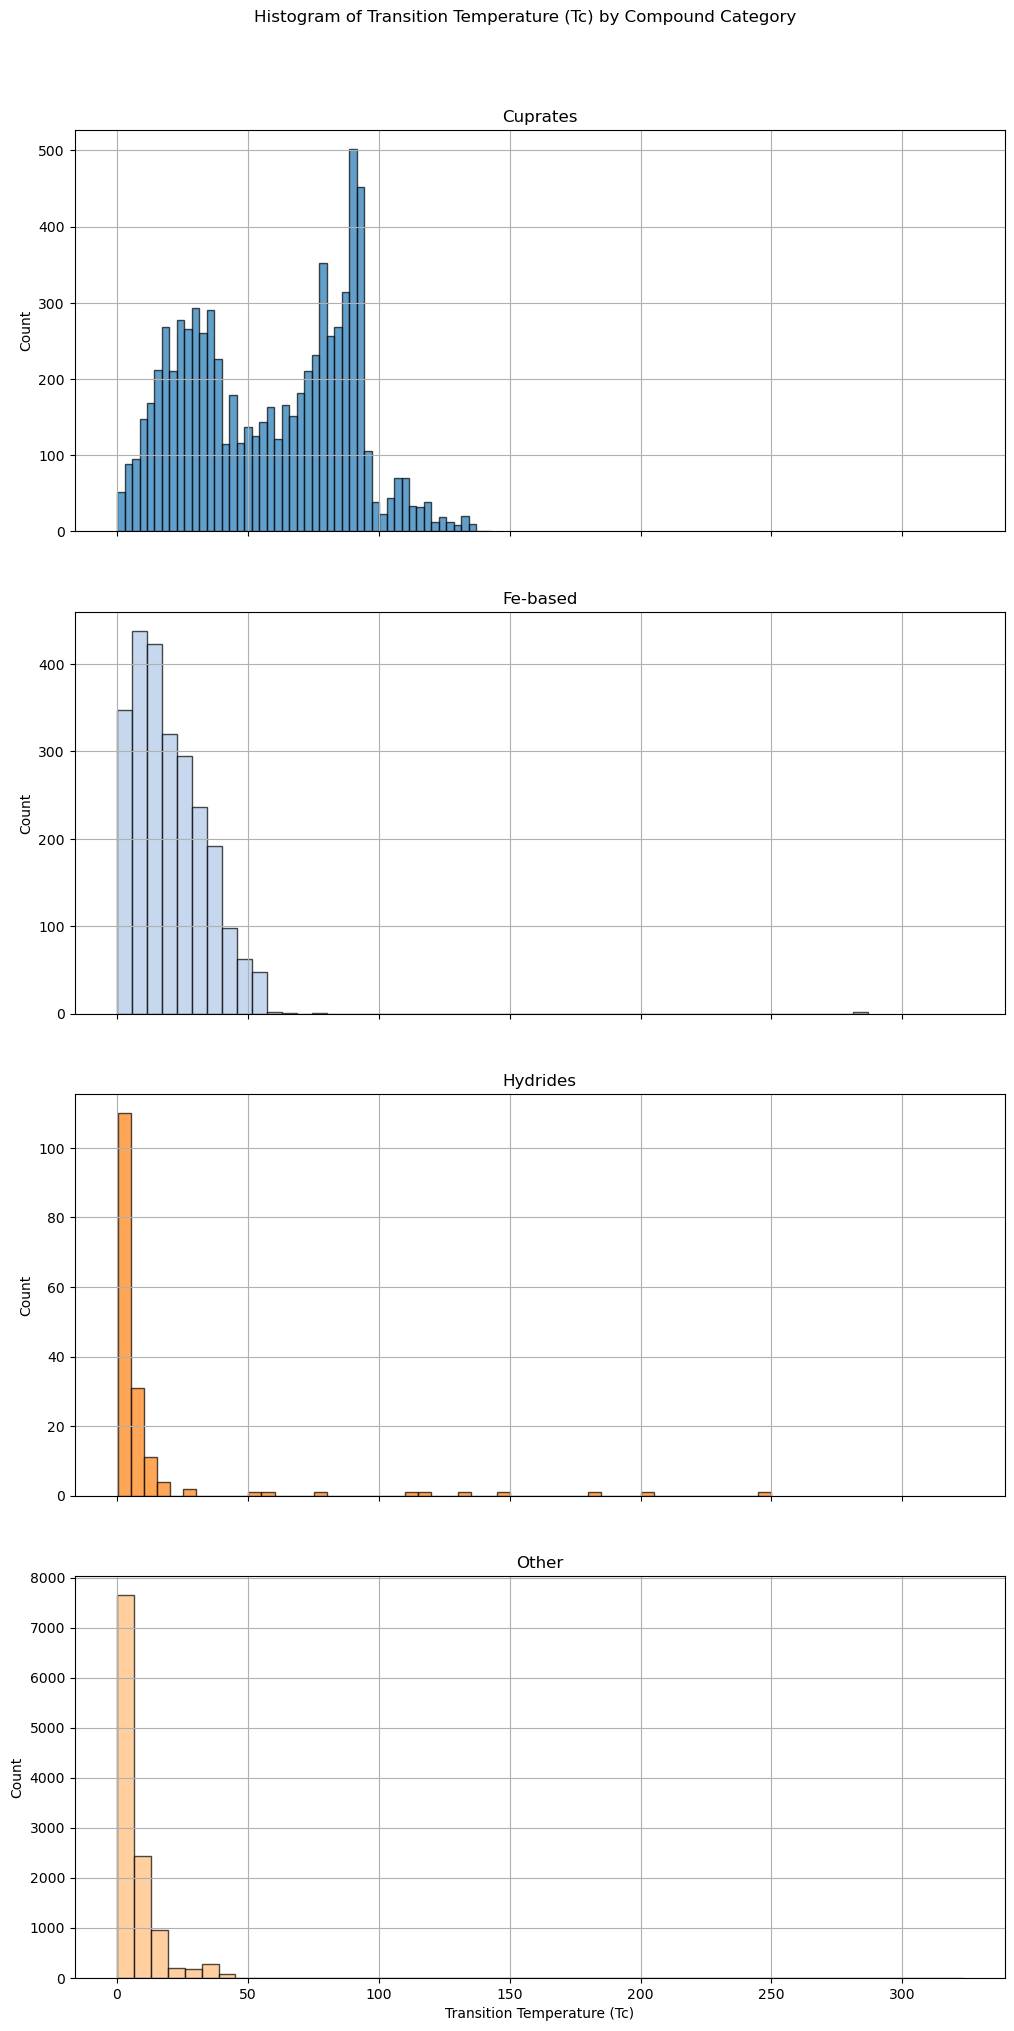

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(12, 24), sharex=True)

for ax, category, color in zip(axs, categories, colors):
    subset = supercond_df[supercond_df['Category'] == category]
    ax.hist(subset['Tc'], bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{category}')
    ax.set_ylabel('Count')
    ax.grid(True)

axs[-1].set_xlabel('Transition Temperature (Tc)')
plt.suptitle('Histogram of Transition Temperature (Tc) by Compound Category', y=0.93)
plt.show()

# Data Cleaning

### TO DO LIST



- dealing with duplicated and missing data
- dealing with problematic data (e.g. too many elements in one compund, too high molar ratio)
- dealing with outliers (1. Transition temeperature outlier i.e. those that doesn't fall within range 0.01 to 136K, 2. number of elements i.e. those with subset of compounds of one, eight, ten elements, 3. summation of subscripts i.e. exceeding 100 are outliers)

### Duplicates and Missing Data

In [25]:
# Remove Duplicates and Missing Data in Chemical_formula

supercond_df = remove_duplicates(supercond_df, 'chemical_formula')
supercond_df = remove_missing(supercond_df, 'chemical_formula')

Number of compounds before removing Duplicates: 21964
Number of compounds after removing Duplicates: 14636
Number of compounds before removing NaN values: 14636
Number of compounds after removing NaN values: 14636


In [26]:
# Remove Duplicates and Missing Data in Stoichiometry

supercond_df = remove_duplicates(supercond_df, 'stoichiometry')
supercond_df = remove_missing(supercond_df, 'stoichiometry')

Number of compounds before removing Duplicates: 14636
Number of compounds after removing Duplicates: 14319
Number of compounds before removing NaN values: 14319
Number of compounds after removing NaN values: 14319


In [27]:
# Remove Missing Data in Tc

supercond_df = remove_missing(supercond_df, 'Tc')

Number of compounds before removing NaN values: 14319
Number of compounds after removing NaN values: 14319


### Problematic Data

In [28]:
# 1) Eliminate compounds with element subscripts X, Y, Z, D, x, y, z, and d
# 2) Remove problematic compounds with specified names
# 3) Remove compounds created under non-ambient pressures
# 4) Eliminate the specific compound with an incorrect oxygen subscript
# 5) Dismiss compounds whose transition temperatures are reported to be zero
# 6) Discard the specific compound due to the unreasonable transition temperature
# 7) Removing compounds that are not in the periodic table

supercond_df = clean_problematic(supercond_df)

Number of compounds before removal of problematic data: 14319
Number of compounds after removal of problematic data: 8917


### Detecting Outlier

In [29]:
# 1) Remove transition temperature outliers
# 2) Remove rows with problematic number of elements
# 3) Remove rows where summation of subscripts exceeds 100 using the stoichiometry column

supercond_df = clean_outliers(supercond_df)

Number of compounds before outlier removal: 8917
Number of compounds after outlier removal: 8838


## Data Visualization after Cleaning Process

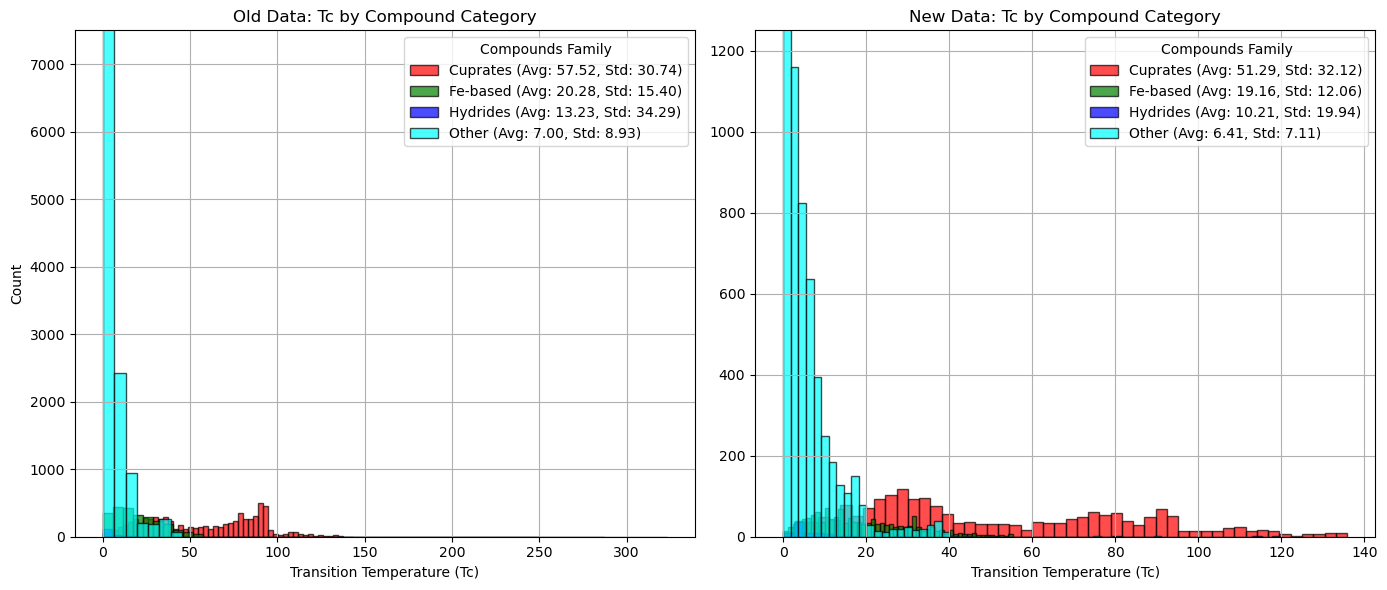

In [30]:
# Classify compounds for old_supercond_df
old_supercond_df['Category'] = old_supercond_df['composition'].apply(classify_compound)

# Classify compounds for supercond_df
supercond_df['Category'] = supercond_df['composition'].apply(classify_compound)

# Define categories and colors
categories = ['Cuprates', 'Fe-based', 'Hydrides', 'Other']
colors = ['red', 'green', 'blue', 'cyan']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for old_supercond_df
for category, color in zip(categories, colors):
    subset = old_supercond_df[old_supercond_df['Category'] == category]
    avg_Tc = subset['Tc'].mean()
    std_Tc = subset['Tc'].std()
    axs[0].hist(subset['Tc'], bins=50, alpha=0.7, label=f'{category} (Avg: {avg_Tc:.2f}, Std: {std_Tc:.2f})', color=color, edgecolor='black')
axs[0].set_xlabel('Transition Temperature (Tc)')
axs[0].set_ylabel('Count')
axs[0].set_title('Old Data: Tc by Compound Category')
axs[0].legend(title='Compounds Family')
axs[0].grid(True)
axs[0].set_ylim(0, 7500)  # Set y-axis limit for the first subplot

# Plot for supercond_df
for category, color in zip(categories, colors):
    subset = supercond_df[supercond_df['Category'] == category]
    avg_Tc = subset['Tc'].mean()
    std_Tc = subset['Tc'].std()
    axs[1].hist(subset['Tc'], bins=50, alpha=0.7, label=f'{category} (Avg: {avg_Tc:.2f}, Std: {std_Tc:.2f})', color=color, edgecolor='black')
axs[1].set_xlabel('Transition Temperature (Tc)')
axs[1].set_title('New Data: Tc by Compound Category')
axs[1].legend(title='Compounds Family')
axs[1].grid(True)
axs[1].set_ylim(0, 1250)  # Set y-axis limit for the second subplot

# Adjust layout
plt.tight_layout()
plt.show()

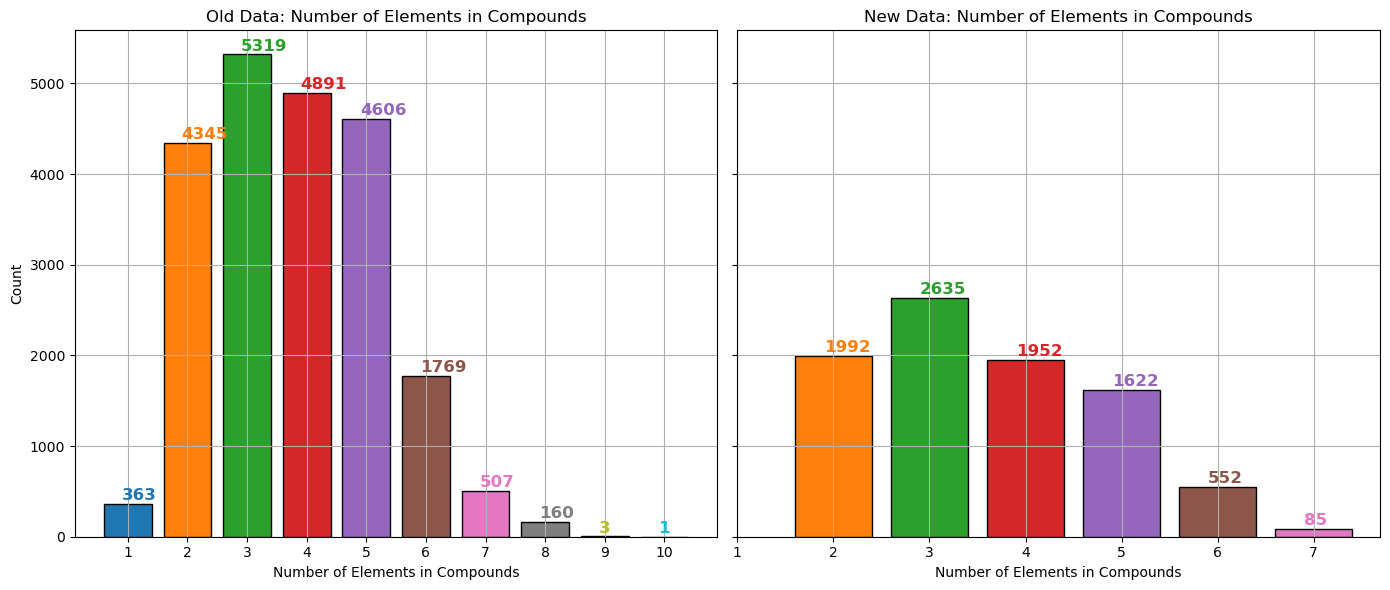

In [31]:
# Count the number of elements in each compound for old_supercond_df
old_supercond_df['num_elements'] = old_supercond_df['elements'].apply(len)

# Count the number of elements in each compound for supercond_df
supercond_df['num_elements'] = supercond_df['elements'].apply(len)

# Get the element counts for both DataFrames
element_counts_old = old_supercond_df['num_elements'].value_counts().sort_index()
element_counts_new = supercond_df['num_elements'].value_counts().sort_index()

# Define colors for each number of elements
element_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
    6: 'tab:brown',
    7: 'tab:pink',
    8: 'tab:gray',
    9: 'tab:olive',
    10: 'tab:cyan'
}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for old_supercond_df
bars_old = axs[0].bar(element_counts_old.index, element_counts_old.values, color=[element_colors[i] for i in element_counts_old.index], edgecolor='black')
for bar in bars_old:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 10, int(yval), va='bottom', color=bar.get_facecolor(), fontsize=12, fontweight='bold')
axs[0].set_xlabel('Number of Elements in Compounds')
axs[0].set_ylabel('Count')
axs[0].set_title('Old Data: Number of Elements in Compounds')
axs[0].set_xticks(np.arange(1, old_supercond_df['num_elements'].max() + 1, step=1))
axs[0].grid(True)

# Plot for supercond_df
bars_new = axs[1].bar(element_counts_new.index, element_counts_new.values, color=[element_colors[i] for i in element_counts_new.index], edgecolor='black')
for bar in bars_new:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 10, int(yval), va='bottom', color=bar.get_facecolor(), fontsize=12, fontweight='bold')
axs[1].set_xlabel('Number of Elements in Compounds')
axs[1].set_title('New Data: Number of Elements in Compounds')
axs[1].set_xticks(np.arange(1, supercond_df['num_elements'].max() + 1, step=1))
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
# Download the processed data

supercond_df.to_csv('cleaned_supercond_df.csv', index=False)

FileLink(r'cleaned_supercond_df.csv')

/Users/chalachkasemtantikul/Downloads/cleaned_supercond_df.csv

# Feature Engineering

## Feature Set 1

In [33]:
# More features extraction using pymatgen

element_properties = [
    'van_der_waals_radius',
    'mendeleev_no',
    'electrical_resistivity',
    'velocity_of_sound',
    'reflectivity',
    'refractive_index',
    'poissons_ratio',
    'molar_volume',
    'thermal_conductivity',
    'boiling_point',
    'melting_point',
    'critical_temperature',
    'superconduction_temperature',
    'liquid_range',
    'bulk_modulus',
    'youngs_modulus',
    'brinell_hardness',
    'rigidity_modulus',
    'mineral_hardness',
    'vickers_hardness',
    'density_of_solid',
    'coefficient_of_linear_thermal_expansion',
]


In [34]:
element_data = "https://materialsvirtuallab.github.io/nano281/assets/element_properties.csv"
element_df = pd.read_csv(element_data, index_col=0)

new_columns = element_df.index.map(add_element_properties)

element_df = pd.concat([element_df, pd.DataFrame(new_columns.tolist(), index=element_df.index)], axis=1)

# Missing data imputation for element_df

missing_percentage = (element_df.isnull().sum() / len(element_df)) * 100
missing_perc_table = pd.DataFrame(missing_percentage)
# display(missing_perc_table)

cutoff_threshold = 20
columns_to_drop = missing_percentage[missing_percentage > cutoff_threshold].index

filtered_element_df = element_df.drop(columns=columns_to_drop)

# Convert all columns to numeric type
element_df = filtered_element_df
element_df = element_df.apply(pd.to_numeric, errors='coerce')

# Now fill missing values with the mean
column_means = element_df.mean(skipna=True)
element_df = element_df.fillna(column_means)

/Users/chalachkasemtantikul/anaconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for electrical_resistivity for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/Users/chalachkasemtantikul/anaconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for reflectivity for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/Users/chalachkasemtantikul/anaconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:223: UserWarning: Ambiguous values (1.000132 (gas; liquid 1.12)(no units)) for refractive_index of H. Returning first float value.
  warnings.warn(
/Users/chalachkasemtantikul/anaconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for poissons_ratio for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/Users/chalachkasemtantikul/anaconda3/lib/python3.11/site-packages

In [35]:
display(element_df)

,AtomicRadius,AtomicVolume,AtomicWeight,BoilingT,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,SecondIonizationEnergy,van_der_waals_radius,mendeleev_no,electrical_resistivity,molar_volume,thermal_conductivity,boiling_point,melting_point,liquid_range,density_of_solid
H,0.250000,18618.051940,1.007940,20.13,31,0.0899,72.800000,2.200000,13.598443,14.304000,18.947504,1.10,103.0,1.234580e+21,11.42,0.1805,20.280000,14.01,6.270000,8431.037975
He,1.500682,37236.035560,4.002602,4.07,28,0.1785,0.000000,1.747033,24.587387,5.130000,54.417760,1.40,1.0,1.234580e+21,21.00,0.1513,4.220000,0.95,3.270000,8431.037975
Li,1.450000,21.544058,6.941000,1615.00,128,535.0000,59.600000,0.980000,5.391719,3.582000,75.640000,1.82,12.0,9.500000e-08,13.02,85.0000,1615.000000,453.69,1161.310000,535.000000
Be,1.050000,8.098176,9.012182,2743.00,96,1848.0000,0.000000,1.570000,9.322700,1.825000,18.211140,1.53,77.0,3.800000e-08,4.85,190.0000,2742.000000,1560.00,1182.000000,1848.000000
B,0.850000,7.297767,10.811000,4273.00,84,2460.0000,26.700000,2.040000,8.298020,1.026000,25.154800,1.92,86.0,1.000000e+12,4.39,27.0000,4200.000000,2349.00,1851.000000,2460.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pa,1.800000,24.961161,231.035860,4273.00,200,15370.0000,76.162209,1.500000,5.890000,0.635447,18.947504,2.10,46.0,1.800000e-07,15.18,47.0000,2538.054891,1841.00,1266.158152,15370.000000
U,1.750000,20.748847,238.028910,4200.00,196,19050.0000,76.162209,1.380000,6.194100,0.116000,10.600000,2.41,45.0,2.800000e-07,12.49,27.0000,4200.000000,1405.30,2794.700000,19050.000000
Np,1.750000,19.244839,237.000000,4273.00,190,20450.0000,76.162209,1.360000,6.265700,0.635447,18.947504,2.39,44.0,1.200000e-06,11.59,6.0000,4273.000000,910.00,3363.000000,20450.000000
Pu,1.750000,20.447164,244.000000,3503.00,187,19816.0000,76.162209,1.280000,6.026000,0.635447,11.200000,2.43,43.0,1.500000e-06,12.29,6.0000,3503.000000,912.50,2590.500000,19816.000000


In [36]:
properties = element_df.columns

# Feature 1: Average (train_oxides)

average_properties = []

for prop in properties:
    average_properties.append(
        [compute_average_from_composition(i,prop) for i in supercond_df["stoichiometry"]]
    )

average_properties = np.array(average_properties).T

# Feature 2 and 3: Max and Min (train_oxides)

max_properties = []
min_properties = []

for prop in properties:
    max_properties.append(
        [get_maxmin_properties(i,prop,mode="max") for i in supercond_df["stoichiometry"]]
    )
    min_properties.append(
        [get_maxmin_properties(i,prop,mode="min") for i in supercond_df["stoichiometry"]]
    )
    
max_properties = np.array(max_properties).T
min_properties = np.array(min_properties).T

# Feature 4 and 5: STD and Variance (train_oxides)

std_properties = []
var_properties = []

for prop in properties:
    std_properties.append(
        [get_stdvar_properties(i, prop, mode="std") for i in supercond_df["stoichiometry"]]
    )
    var_properties.append(
        [get_stdvar_properties(i, prop, mode="var") for i in supercond_df["stoichiometry"]]
    )

std_properties = np.array(std_properties).T
var_properties = np.array(var_properties).T

In [37]:
# Concatenate

design_matrix = np.concatenate([average_properties,max_properties,min_properties,std_properties,var_properties], axis=1)

column_names = (
        [f"Average {n}" for n in properties]
        + [f"Max {n}" for n in properties]
        + [f"Min {n}" for n in properties]
        + [f"Std {n}" for n in properties]
        + [f"Var {n}" for n in properties])

design_matrix = pd.DataFrame(design_matrix, columns=column_names)
# design_matrix = design_matrix.dropna()
display(design_matrix)

,Average AtomicRadius,Average AtomicVolume,Average AtomicWeight,Average BoilingT,Average CovalentRadius,Average Density,Average ElectronAffinity,Average Electronegativity,Average FirstIonizationEnergy,Average HeatCapacityMass,...,Var SecondIonizationEnergy,Var van_der_waals_radius,Var mendeleev_no,Var electrical_resistivity,Var molar_volume,Var thermal_conductivity,Var boiling_point,Var melting_point,Var liquid_range,Var density_of_solid
0,1.097143,10637.113673,57.873967,1542.185714,115.885714,2974.616571,110.470357,2.546929,10.471085,0.635479,...,135.164665,0.264092,1523.333333,3.810471e+41,167.439767,38015.674180,2.599991e+06,3.399192e+05,1.148678e+06,6.132397e+06
1,1.093929,10636.906970,56.808817,1531.728571,115.457143,2955.759429,110.279214,2.548214,10.481439,0.637664,...,129.191499,0.205667,1496.250000,3.810471e+41,124.332467,37070.682203,2.708668e+06,3.438311e+05,1.310583e+06,8.227830e+06
2,1.047143,10635.250819,67.135606,1514.857143,110.800000,3905.930857,110.741429,2.589143,10.429637,0.625000,...,121.916689,0.237333,1756.250000,3.810471e+41,169.264558,37828.410890,2.535461e+06,6.161797e+05,6.914286e+05,8.053466e+06
3,1.094643,10637.075533,56.330499,1519.428571,115.571429,2899.123714,109.180857,2.544571,10.475865,0.639450,...,103.621973,0.154270,1125.800000,3.048377e+41,111.528070,29423.250881,2.416782e+06,4.688633e+05,1.008979e+06,6.990802e+06
4,1.094286,10637.036937,56.424486,1517.542857,115.401429,2926.630857,109.875429,2.546757,10.480881,0.638606,...,101.420671,0.154430,1122.500000,3.048377e+41,121.476230,29115.426959,2.486284e+06,5.800001e+05,9.943462e+05,6.206448e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833,1.196667,26.523951,80.111022,1944.373667,130.100000,5445.850000,74.800000,1.962833,9.149645,0.550150,...,19.144693,0.063092,1235.666667,2.500000e+45,3.656692,132.066534,4.665429e+06,1.213615e+06,1.120451e+06,3.326874e+07
8834,1.203333,26.765795,79.993582,1904.340333,130.500000,5330.216667,76.466667,1.961833,9.103004,0.550483,...,19.144693,0.063092,1235.666667,2.500000e+45,3.656692,132.066534,4.665429e+06,1.213615e+06,1.120451e+06,3.326874e+07
8835,1.210000,27.007639,79.876142,1864.307000,130.900000,5214.583333,78.133333,1.960833,9.056364,0.550817,...,19.144693,0.063092,1235.666667,2.500000e+45,3.656692,132.066534,4.665429e+06,1.213615e+06,1.120451e+06,3.326874e+07
8836,1.216667,27.249483,79.758702,1824.273667,131.300000,5098.950000,79.800000,1.959833,9.009724,0.551150,...,19.144693,0.063092,1235.666667,2.500000e+45,3.656692,132.066534,4.665429e+06,1.213615e+06,1.120451e+06,3.326874e+07


## Feature Set 2

In [38]:
data = supercond_df.copy()
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()

In [39]:
# Automatic Featurizer

data = feature_calculators.featurize_dataframe(data, col_id='composition',ignore_errors=True);
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

MultipleFeaturizer:   0%|          | 0/8838 [00:00<?, ?it/s]

Generated 145 features
Training set size: 8838x145


## Dowload Files Feature 1 and 2

In [21]:
# Download the file design matrix 1

design_matrix.to_csv('supercond_df.csv', index=False)

FileLink(r'supercond_df.csv')

/Users/chalachkasemtantikul/Downloads/design_matrix_supercond_1.csv

In [40]:
# Download the file design matrix 2

selected_columns = data.columns[7:]
selected_data = pd.DataFrame(data, columns=selected_columns)

display(selected_data)

selected_data.to_csv('design_matrix_supercond_2.csv', index=False)

FileLink(r'design_matrix_supercond_2.csv')

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
20,4,0.645945,0.592474,0.573937,0.571802,0.571454,8.0,57.0,49.0,24.978571,...,95.178571,95.061224,12.0,1.857143,2.285714,1.692857,0.000000,False,0.803211,0.165284
21,4,0.645945,0.592474,0.573937,0.571802,0.571454,8.0,57.0,49.0,24.592857,...,95.092857,94.963265,12.0,1.857143,2.285714,1.692857,0.000000,False,0.787757,0.164994
70,4,0.643333,0.591101,0.573632,0.571738,0.571448,8.0,71.0,63.0,28.571429,...,95.428571,95.346939,12.0,1.857143,2.285714,1.685714,3.600000,False,0.803211,0.155938
74,5,0.641825,0.590704,0.573607,0.571737,0.571448,8.0,57.0,49.0,24.407143,...,95.092857,94.963265,12.0,1.864286,2.285714,1.628571,0.000000,False,0.787757,0.165653
75,5,0.643019,0.591018,0.573627,0.571738,0.571448,8.0,57.0,49.0,24.448571,...,95.320000,95.222857,12.0,1.858571,2.285714,1.675714,0.000000,False,0.787757,0.165292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26315,4,0.585472,0.517181,0.488909,0.484478,0.483462,15.0,72.0,57.0,34.116667,...,78.466667,77.022222,2.0,2.000000,2.183333,0.600000,4.666667,False,0.348856,0.053305
26316,4,0.575905,0.510162,0.486619,0.483833,0.483370,15.0,72.0,57.0,34.083333,...,78.466667,77.022222,2.0,2.000000,2.183333,0.566667,4.666667,False,0.348856,0.053562
26317,4,0.570088,0.505857,0.485402,0.483563,0.483344,15.0,72.0,57.0,34.050000,...,78.466667,77.022222,2.0,2.000000,2.183333,0.533333,4.666667,False,0.348856,0.053819
26318,4,0.568135,0.504406,0.485023,0.483491,0.483339,15.0,72.0,57.0,34.016667,...,78.466667,77.022222,2.0,2.000000,2.183333,0.500000,4.666667,False,0.348856,0.054076


/Users/chalachkasemtantikul/Downloads/design_matrix_supercond_2.csv

## Combine 2 Feature Set

In [2]:
design_matrix_supercond_1 = pd.read_csv('/Users/chalachkasemtantikul/Downloads/design_matrix_supercond_1.csv')
design_matrix_supercond_2 = pd.read_csv('/Users/chalachkasemtantikul/Downloads/design_matrix_supercond_2.csv')
final_features = pd.concat([design_matrix_supercond_1,design_matrix_supercond_2], axis=1)

final_features.to_csv('final_design_matrix_supercond.csv', index=False)
FileLink(r'final_design_matrix_supercond.csv')

/Users/chalachkasemtantikul/Downloads/final_design_matrix_supercond.csv

In [4]:
final_design_matrix_supercond = pd.read_csv('/Users/chalachkasemtantikul/Downloads/final_design_matrix_supercond.csv')
display(final_design_matrix_supercond)

,Average AtomicRadius,Average AtomicVolume,Average AtomicWeight,Average BoilingT,Average CovalentRadius,Average Density,Average ElectronAffinity,Average Electronegativity,Average FirstIonizationEnergy,Average HeatCapacityMass,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,1.097143,10637.113673,57.873967,1542.185714,115.885714,2974.616571,110.470357,2.546929,10.471085,0.635479,...,95.178571,95.061224,12.0,1.857143,2.285714,1.692857,0.000000,False,0.803211,0.165284
1,1.093929,10636.906970,56.808817,1531.728571,115.457143,2955.759429,110.279214,2.548214,10.481439,0.637664,...,95.092857,94.963265,12.0,1.857143,2.285714,1.692857,0.000000,False,0.787757,0.164994
2,1.047143,10635.250819,67.135606,1514.857143,110.800000,3905.930857,110.741429,2.589143,10.429637,0.625000,...,95.428571,95.346939,12.0,1.857143,2.285714,1.685714,3.600000,False,0.803211,0.155938
3,1.094643,10637.075533,56.330499,1519.428571,115.571429,2899.123714,109.180857,2.544571,10.475865,0.639450,...,95.092857,94.963265,12.0,1.864286,2.285714,1.628571,0.000000,False,0.787757,0.165653
4,1.094286,10637.036937,56.424486,1517.542857,115.401429,2926.630857,109.875429,2.546757,10.480881,0.638606,...,95.320000,95.222857,12.0,1.858571,2.285714,1.675714,0.000000,False,0.787757,0.165292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833,1.196667,26.523951,80.111022,1944.373667,130.100000,5445.850000,74.800000,1.962833,9.149645,0.550150,...,78.466667,77.022222,2.0,2.000000,2.183333,0.600000,4.666667,False,0.348856,0.053305
8834,1.203333,26.765795,79.993582,1904.340333,130.500000,5330.216667,76.466667,1.961833,9.103004,0.550483,...,78.466667,77.022222,2.0,2.000000,2.183333,0.566667,4.666667,False,0.348856,0.053562
8835,1.210000,27.007639,79.876142,1864.307000,130.900000,5214.583333,78.133333,1.960833,9.056364,0.550817,...,78.466667,77.022222,2.0,2.000000,2.183333,0.533333,4.666667,False,0.348856,0.053819
8836,1.216667,27.249483,79.758702,1824.273667,131.300000,5098.950000,79.800000,1.959833,9.009724,0.551150,...,78.466667,77.022222,2.0,2.000000,2.183333,0.500000,4.666667,False,0.348856,0.054076
